# Case: Seguro de Sa√∫de - Previs√£o de Custos M√©dicos

O objetivo √© desenvolver um modelo preditivo de regress√£o para prever o valor dos custos m√©dicos individuais cobrados pelo seguro de sa√∫de.

Para isso, faremos:

1. Identifica√ß√£o e An√°lise Explorat√≥ria de Dados (AED)
2. Limpeza dos dados
3. Treinamento dos modelos e Valida√ß√£o Cruzada
3. Ranking de modelos
4. Relat√≥rios e Otimiza√ß√£o
5. Insights e conclus√£o

Queremos estar certos que o modelo entregue estar√° preparado para o uso no mercado.

Membros:

- Gabriel Aguiar (RM 362624)
- Gabriel √Åvila (RM 361385)
- Rafael Luna (RM 362601)
- Rafael Sad (RM 362627)

# Dataset: Fornecido pelo Hugging Face
https://huggingface.co/datasets/rahulvyasm/medical_insurance_data

Tamb√©m dispon√≠vel dentro do reposit√≥rio.



# Identifica√ß√£o e An√°lise Explorat√≥ria de Dados (AED)

Nesta etapa, precisamos entender um pouco mais com quais dados estamos lidando, se temos dados faltando, duplicados, que precisam de algum tratamento.

In [43]:
import pandas as pd

df = pd.read_csv('medical_insurance.csv')

print("\n ----- Head ----- \n")
print(df.head())

print("\n ----- Tail ----- \n")
print(df.tail())

print("\n ----- Info ----- \n")
print(df.info())

print("\n ----- Size per column ----- \n")
print(df.count())

print("\n ----- Shape (rows,columns) ----- \n")
print(df.shape)

print("\n ----- Missing data ----- \n")
print(df.isnull().sum())

print("\n ----- Duplicated rows ----- \n")
print(df.duplicated().sum())

print("\n ----- Descriptive statistics ----- \n")
print(df.describe())

print("\n ----- String columns and values ----- \n")
print('smoker', set(df['smoker']))
print('sex', set(df['sex']))
print('region', set(df['region']))


 ----- Head ----- 

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

 ----- Tail ----- 

      age     sex     bmi  children smoker     region      charges
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200

 ----- Info ----- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  -

## Identifica√ß√£o

- 1435 linhas duplicadas (mais de 50% do dataset)
- Idades entre 18 a 64 anos, m√©dia 39 anos
- IMCs entre 15 a 53, um desvio m√©dio de 6,12 (relativamente bom)
- De 0 a 5 filhos, m√©dia de 1 filho
- Cobran√ßas entre 1,221.87 at√© 63,770.42, com a m√©dia de $9,333.01, indicando outliers (antes da an√°lise do gr√°fico)
- Os valores das strings est√£o limpos o suficiente para transforma√ß√£o em n√∫mero. Nenhum campo faltando e categorias bem definidas

<br />

| Problema     |      A√ß√£o      |
|--------------|--------------------|
| 1435 linhas duplicadas (mais de 50% do dataset) |  Remover duplicadas |
| Outliers em pre√ßos | Entender melhor e lidar com outliers |
| Campos em texto | Manipular os dados para que sejam entend√≠veis para os modelos (nros) |


Ainda precisamos entender melhor como estes dados est√£o relacionados com o pre√ßo. Para isso, vamos remover as duplicadas e partir para mais an√°lises.



In [2]:
# Removendo duplicadas antes dos gr√°ficos
df = df.drop_duplicates();

## An√°lise Explorat√≥ria de Dados (AED)

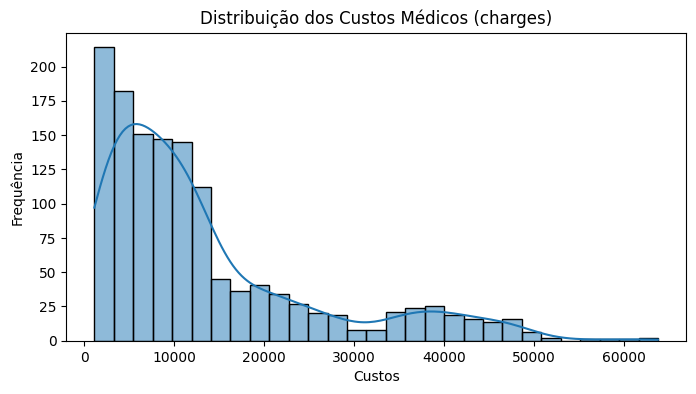

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["charges"], kde=True)
plt.title("Distribui√ß√£o dos Custos M√©dicos (charges)")
plt.xlabel("Custos")
plt.ylabel("Frequ√™ncia")
plt.show()

- Distribui√ß√£o assim√©trica √† esquerda
- Outliers puxando dados para acima da casa dos $50k

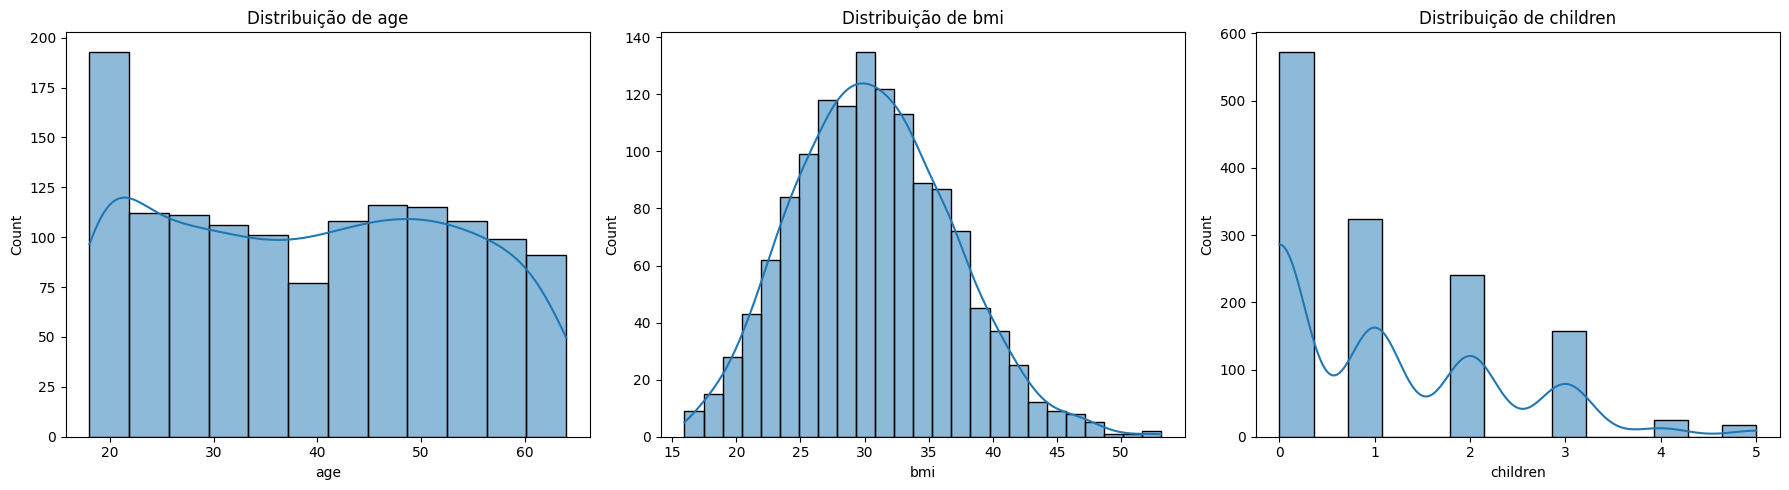

In [4]:
# Number Variables
numerical_cols = ["age", "bmi", "children"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribui√ß√£o de {col}")

plt.tight_layout()
plt.show()

- Distribui√ß√£o quase sim√©trica da idade (age), com uma propor√ß√£o maior para < 20 anos
- IMC (bmi) alto na casa dos 24~34
- Muitos com 0 a 1 filhos, 4 e 5 filhos outliers

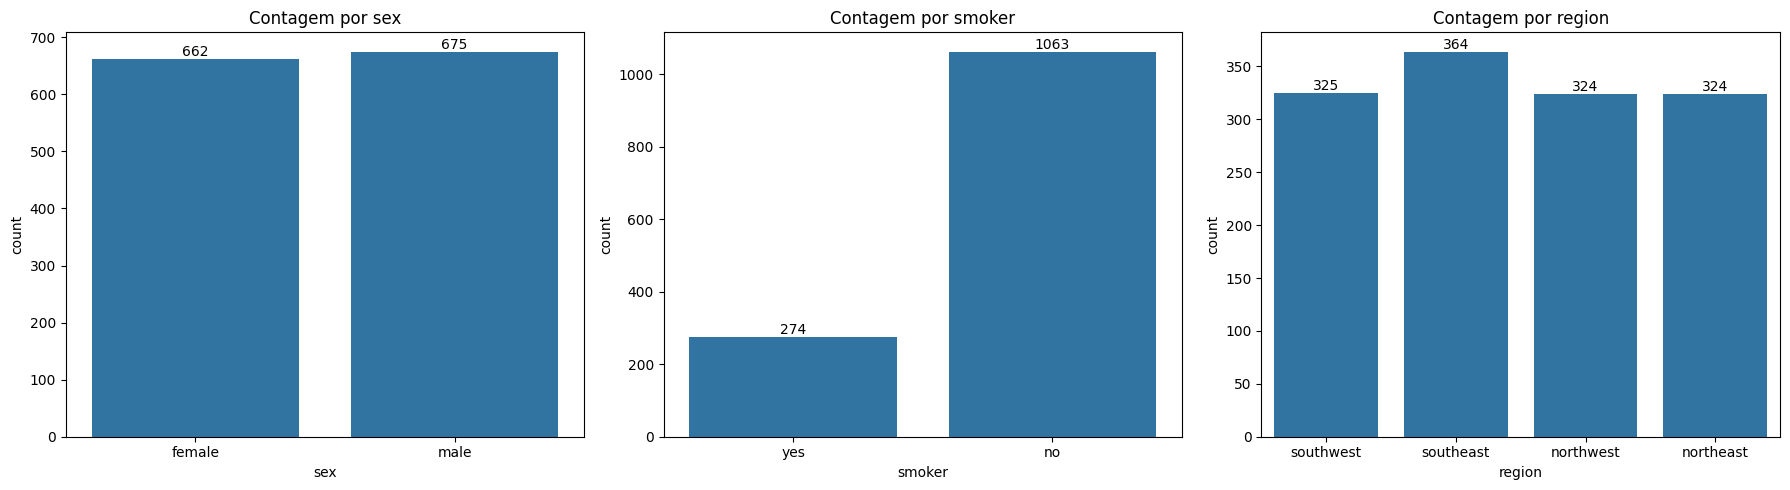

In [5]:
categorical_cols = ["sex", "smoker", "region"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f"Contagem por {col}")

    # Add contagem nas barras
    for container in axes[i].containers:
        axes[i].bar_label(container)

plt.tight_layout()
plt.show()

- Distribui√ß√£o sim√©trica em g√™nero (sex)
- Distribui√ß√£o assim√©trica em fumantes (smoker), temos muito mais dados de n√£o fumantes, o que pode viciar o modelo
- Distribui√ß√£o praticamente sim√©trica em regi√£o (region)

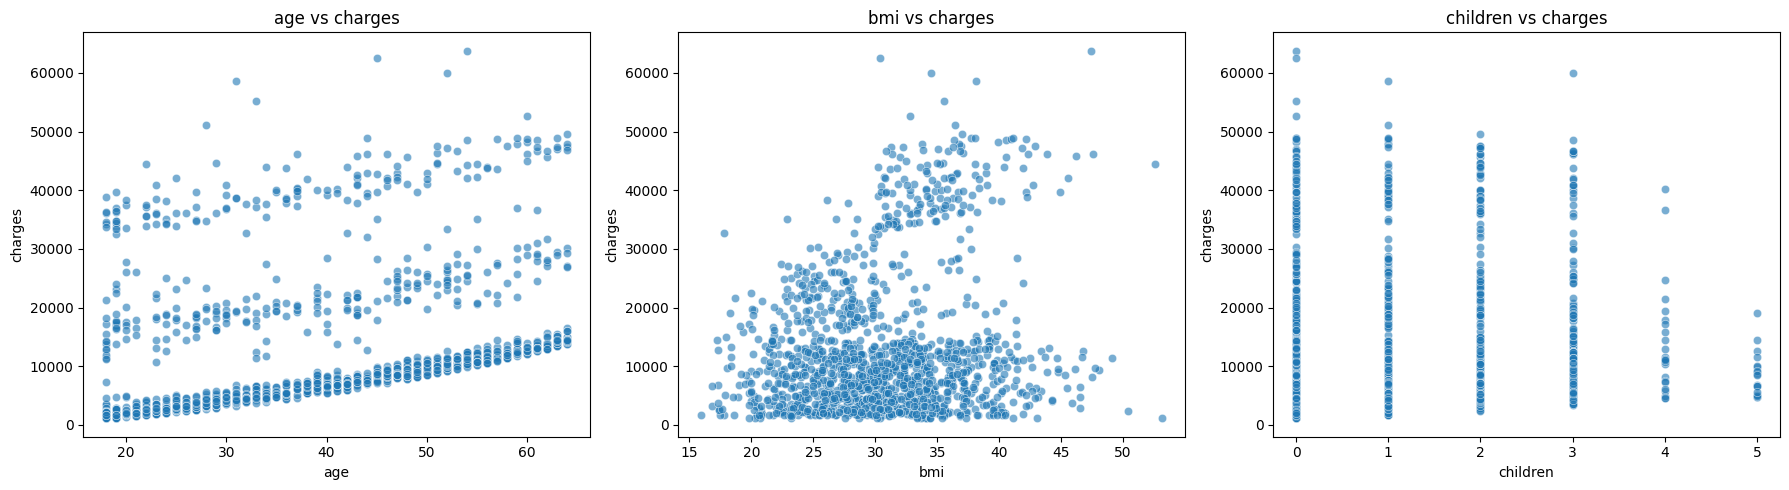

In [6]:
# Rela√ß√£o com vari√°veis num√©ricas (scatter plots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=col, y="charges", data=df, ax=axes[i], alpha=0.6)
    axes[i].set_title(f"{col} vs charges")

plt.tight_layout()
plt.show()

- Vemos uma leve tend√™ncia para quanto maior a idade, maior o custo
- Filhos n√£o parecem influenciar tanto os custos, pelo contr√°rio, uma leve indica√ß√£o que fam√≠lias com mais filhos podem trazer menos custos para a seguradora
- IMCs acima de 30 (Obesidade) apresentam maiores chances na eleva√ß√£o dos custos m√©dicos

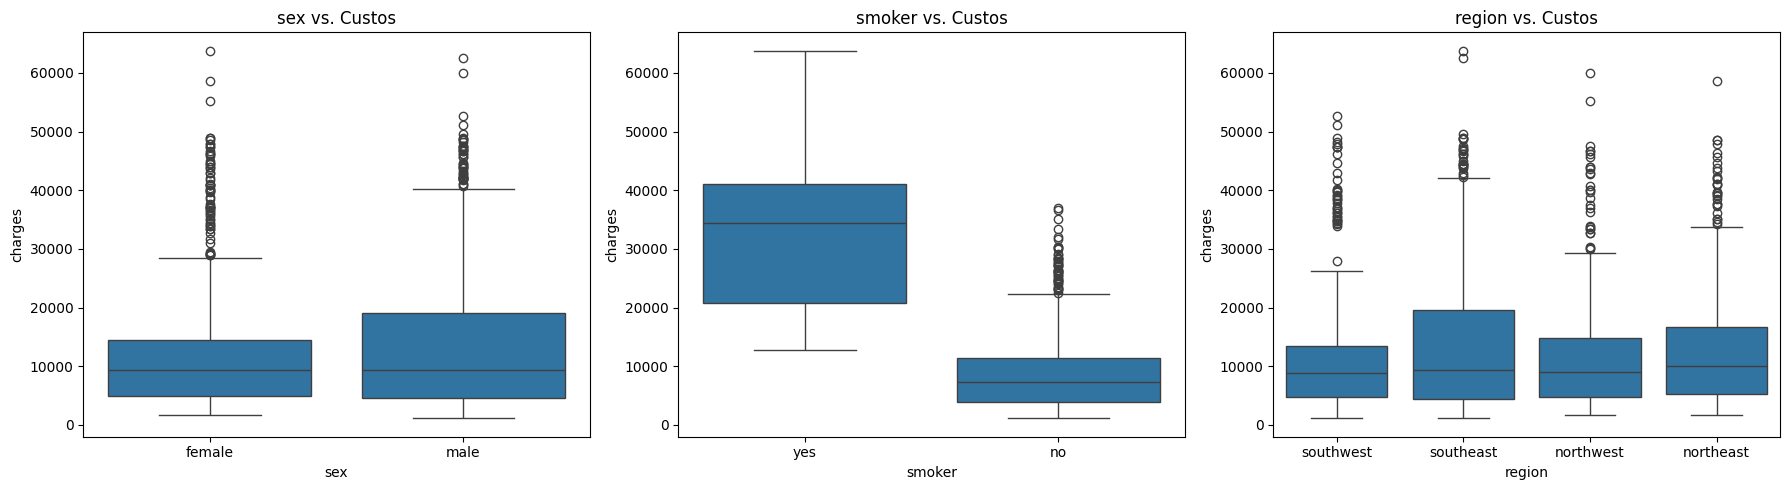

In [7]:
# Rela√ß√£o com vari√°veis categ√≥ricas (box plots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y="charges", data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs. Custos")

plt.tight_layout()
plt.show()

- Homens costumar ter mais custos m√©dicos do que as mulheres
- Fumantes tem uma grande chance de ter o dobrou ou mais de custos m√©dicos do que n√£o fumantes
- N√£o fumantes tamb√©m podem ter o dobro de gastos por outras condi√ß√µes (possivelmente, devido ao IMC/BMI)
- Todas as regi√µes possuem outliers em custos m√©dicos, mostrando que n√£o afetam tanto assim a predi√ß√£o

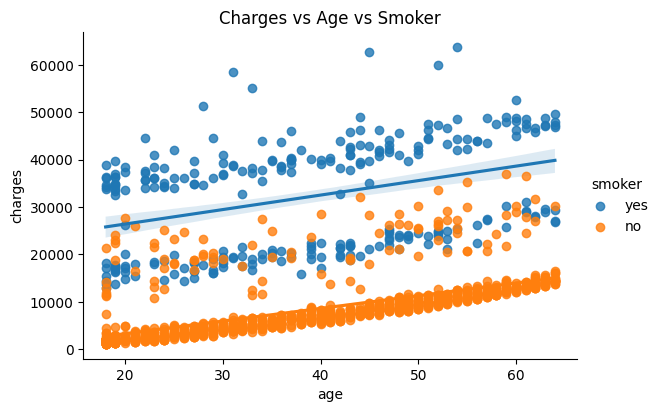

In [8]:
# Rela√ß√£o de mais de uma vari√°vel com o custo (smoker, age, bmi)
sns.lmplot(x="age", y="charges", hue="smoker", data=df, height=4, aspect=1.5)
plt.title("Charges vs Age vs Smoker")
plt.show()

- Smoker √© um fator muito decisivo para os custos
- Vemos apenas 1 n√£o fumante outlier passando a linha m√©dia

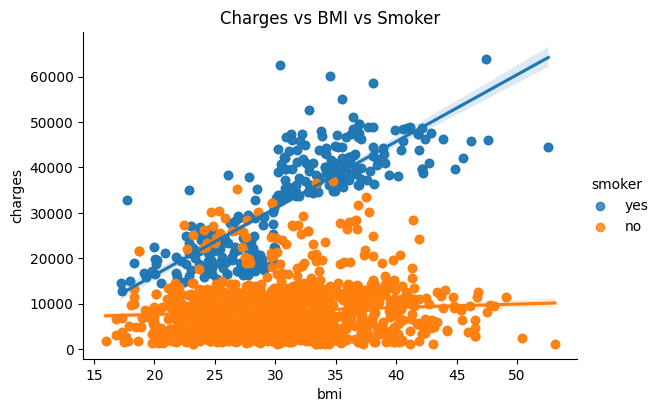

In [44]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, height=4, aspect=1.5)
plt.title("Charges vs BMI vs Smoker")
plt.show()

- O IMC √© um bom candidato para indicar custos maiores, mas n√£o tanto quanto os fumantes

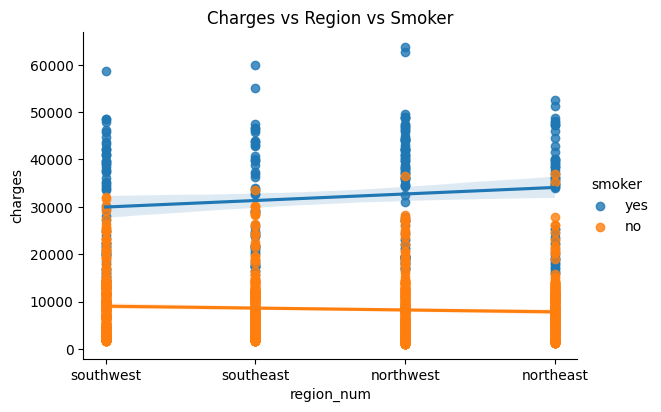

In [10]:
# Convert regions into numbers
df['region_num'] = df['region'].astype('category').cat.codes

sns.lmplot(x="region_num", y="charges", hue="smoker", data=df, height=4, aspect=1.5)
plt.title("Charges vs Region vs Smoker")
plt.xticks(
    ticks=df['region_num'].unique(),
    labels=df['region'].astype('category').cat.categories
)
plt.show()

- O campo `region` n√£o se mostrou muito efetivo para este conjunto de dados
- Temos alguns outliers em todas as regi√µes
- `Northeast` √© a regi√£o com menos outliers e outliers mais baratos

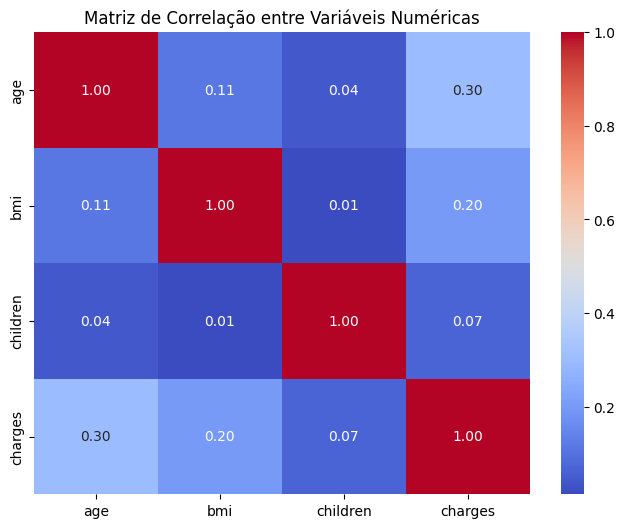

Correla√ß√£o com a vari√°vel 'charges':
charges     1.000000
age         0.298308
bmi         0.198401
children    0.067389
Name: charges, dtype: float64


In [11]:
# Correla√ß√£o entre vari√°veis num√©ricas
numerical_df = df.select_dtypes(include=["int64", "float64"])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correla√ß√£o entre Vari√°veis Num√©ricas")
plt.show()

print("Correla√ß√£o com a vari√°vel 'charges':")
print(correlation_matrix["charges"].sort_values(ascending=False))

- Idade (age) tem uma forte rela√ß√£o com custos (charges)
- IMC (bmi) possui uma certa rela√ß√£o com os custos (charges)

# Limpeza dos dados

Visto a an√°lise dos dados, faremos as seguintes limpezas:

- **Remover strings de sex, smoker**: Para entendimento dos modelos
- **Standard Scale**: Para jogar os dados dentro de uma escala padronizada para evitar que n√∫meros grandes se sobressaiam e o modelo n√£o foque nos padr√µes

Deixamos de fora as seguintes estrat√©gias:

- **Log nos custos**: Depois de alguns testes, n√£o se mostrou muito efetivo
- **Remover o campo region**: Depois de alguns testes, tamb√©m n√£o teve um grande impacto na predi√ß√£o



In [12]:
# One-hot encoding, remove strings
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True, dtype=int)

print("\n ----- Transformed data ----- \n")
print(df.info())


 ----- Transformed data ----- 

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   region_num        1337 non-null   int8   
 5   sex_male          1337 non-null   int64  
 6   smoker_yes        1337 non-null   int64  
 7   region_northwest  1337 non-null   int64  
 8   region_southeast  1337 non-null   int64  
 9   region_southwest  1337 non-null   int64  
dtypes: float64(2), int64(7), int8(1)
memory usage: 105.8 KB
None


# Treinamento dos modelos e Valida√ß√£o Cruzada

Faremos o treinamento com os seguintes modelos de Regress√£o:

- Linear Regression
- Ridge
- Lasso
- ElasticNet
- Decision Tree
- Random Forest
- Gradient Boosting
- AdaBoost
- XGBoost
- LightGBM
- SVR
- KNN

Ap√≥s isso, faremos a valida√ß√£o cruzada para todos eles e faremos mais um treinamento com os melhores par√¢metros.

Por fim, repetiremos o mesmo processo para os dados

### Treinamento
Primeiramente vamos separar os dados de treino em teste para com e sem regi√£o. Usaremos o padr√£o 80/20.

Tamb√©m usaremos o `stratify=yes` para mantermos uma boa distribui√ß√£o dos dados. Por exemplo, queremos evitar que os dados de teste contenham apenas 10% dos smokers

**Fun√ß√µes**

Vamos criar algumas fun√ß√µes que v√£o nos ajudar e separar os dados de teste em 80/20

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred, model_name):
    """Calcula m√©tricas de avalia√ß√£o"""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {
        'Modelo': model_name,
        'R¬≤': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

In [14]:
# Separating data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 80/20 strategy
X = df.drop("charges", axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["smoker_yes"])

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Treinando os modelos:

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Data to keep models results
models = {}
results = []

print("\n ----- Training ----- \n")

# Regress√£o Linear Simples
print("Treinando Linear Regression...")
models['Linear Regression'] = LinearRegression()
models['Linear Regression'].fit(X_train_scaled, y_train)

# Ridge Regression
print("Treinando Ridge Regression...")
models['Ridge'] = Ridge(alpha=1.0, random_state=42)
models['Ridge'].fit(X_train_scaled, y_train)

# Lasso Regression
print("Treinando Lasso Regression...")
models['Lasso'] = Lasso(alpha=1.0, random_state=42, max_iter=1000)
models['Lasso'].fit(X_train_scaled, y_train)

# Elastic Net
print("Treinando ElasticNet...")
models['ElasticNet'] = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=1000)
models['ElasticNet'].fit(X_train_scaled, y_train)

# Decision Tree
print("Treinando Decision Tree...")
models['Decision Tree'] = DecisionTreeRegressor(max_depth=10, random_state=42)
models['Decision Tree'].fit(X_train, y_train)

# Random Forest
print("Treinando Random Forest...")
models['Random Forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
models['Random Forest'].fit(X_train, y_train)

# Support Vector Regression
print("Treinando SVR...")
models['SVR'] = SVR(kernel='rbf', C=1000, gamma=0.1)
models['SVR'].fit(X_train_scaled, y_train)

# K-Nearest Neighbors
print("Treinando KNN...")
models['KNN'] = KNeighborsRegressor(n_neighbors=5)
models['KNN'].fit(X_train_scaled, y_train)

# Gradient Boosting
print("Treinando Gradient Boosting...")
models['Gradient Boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
models['Gradient Boosting'].fit(X_train, y_train)

# AdaBoost
print("Treinando AdaBoost...")
models['AdaBoost'] = AdaBoostRegressor(n_estimators=100, random_state=42)
models['AdaBoost'].fit(X_train, y_train)

# XGBoost
print("Treinando XGBoost...")
models['XGBoost'] = XGBRegressor(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
models['XGBoost'].fit(X_train, y_train)

# LightGBM
print("Treinando LightGBM...")
models['LightGBM'] = LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
models['LightGBM'].fit(X_train, y_train)

print(f"\n‚úÖ Total de modelos treinados: {len(models)}")


 ----- Training ----- 

Treinando Linear Regression...
Treinando Ridge Regression...
Treinando Lasso Regression...
Treinando ElasticNet...
Treinando Decision Tree...
Treinando Random Forest...
Treinando SVR...
Treinando KNN...
Treinando Gradient Boosting...
Treinando AdaBoost...
Treinando XGBoost...
Treinando LightGBM...

‚úÖ Total de modelos treinados: 12


**Resultados**

Agora precisamos identificar os resultados dos modelos

In [16]:
scaled_models = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'KNN']

def get_model_results():
  for name, model in models.items():
      # To use the scaled values
      if name in scaled_models:
          X_test_used = X_test_scaled
      else:
          X_test_used = X_test

      y_pred = model.predict(X_test_used)

      metrics = calculate_metrics(y_test, y_pred, name)
      results.append(metrics)

  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values('R¬≤', ascending=False)

  return results_df

results_df = get_model_results()

print("\n ----- Results ----- \n")
print(results_df.round(4))


 ----- Results ----- 

               Modelo      R¬≤        MAE           MSE       RMSE
11           LightGBM  0.8989  2444.1451  1.457925e+07  3818.2781
5       Random Forest  0.8893  2445.1872  1.595701e+07  3994.6227
8   Gradient Boosting  0.8783  2548.6653  1.754775e+07  4189.0033
9            AdaBoost  0.8666  3612.6865  1.922720e+07  4384.8834
10            XGBoost  0.8593  2746.9017  2.028186e+07  4503.5386
7                 KNN  0.8303  3153.1427  2.446148e+07  4945.8546
2               Lasso  0.8205  3592.6352  2.587429e+07  5086.6777
0   Linear Regression  0.8205  3592.7926  2.587635e+07  5086.8799
1               Ridge  0.8205  3593.9950  2.587988e+07  5087.2270
6                 SVR  0.7679  2545.1115  3.345648e+07  5784.1579
4       Decision Tree  0.7602  3030.6452  3.457086e+07  5879.6986
3          ElasticNet  0.7218  4736.3841  4.010141e+07  6332.5676


E agora, alguns gr√°ficos para deixar isso mais vis√≠vel

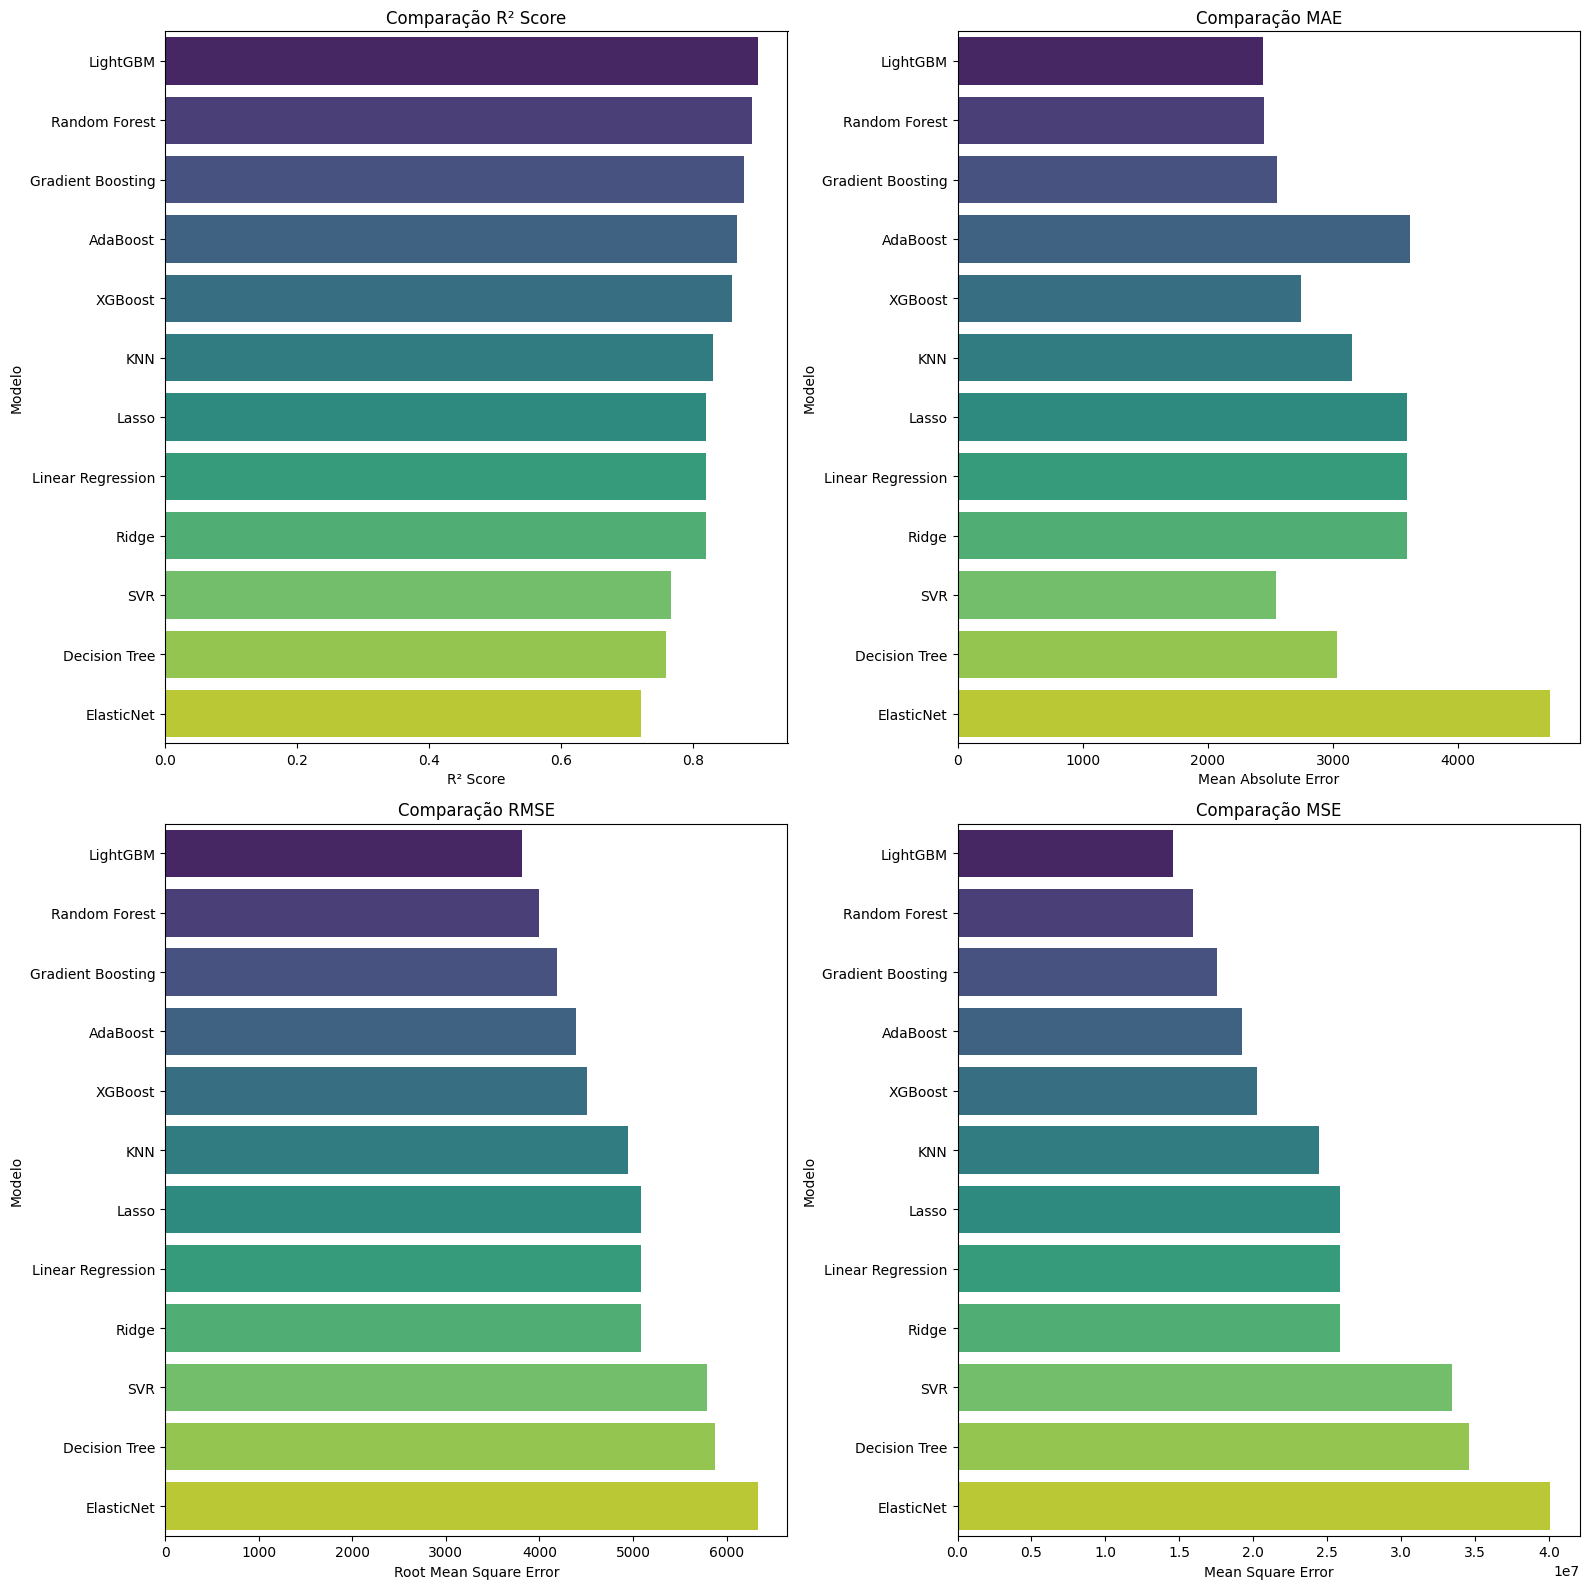

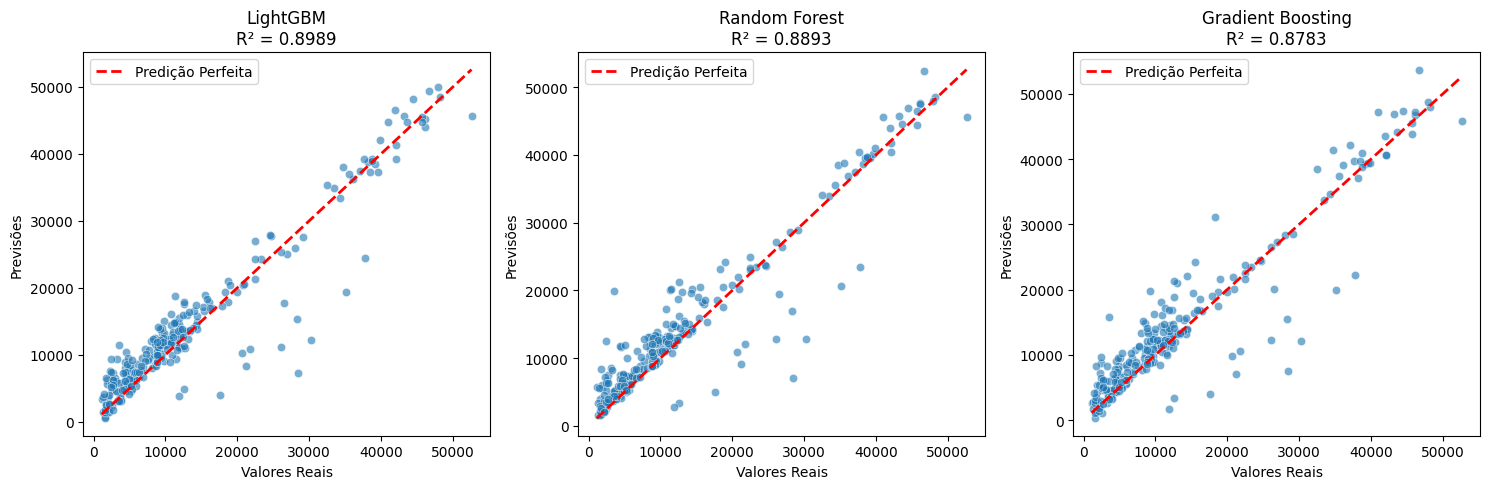

In [17]:
plt.figure(figsize=(16, 16))

# R¬≤
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='R¬≤', y='Modelo', hue='Modelo', palette='viridis')
plt.title('Compara√ß√£o R¬≤ Score')
plt.xlabel('R¬≤ Score')

# MAE
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='MAE', y='Modelo', hue='Modelo', palette='viridis')
plt.title('Compara√ß√£o MAE')
plt.xlabel('Mean Absolute Error')

# RMSE
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x='RMSE', y='Modelo', hue='Modelo', palette='viridis')
plt.title('Compara√ß√£o RMSE')
plt.xlabel('Root Mean Square Error')

# MSE
plt.subplot(2, 2, 4)
sns.barplot(data=results_df, x='MSE', y='Modelo', hue='Modelo', palette='viridis')
plt.title('Compara√ß√£o MSE')
plt.xlabel('Mean Square Error')

plt.tight_layout()
plt.show()

# 6.2 Previs√µes vs Valores Reais para os 3 melhores modelos
top_3_models = results_df.head(3)['Modelo'].tolist()

plt.figure(figsize=(15, 5))

for i, model_name in enumerate(top_3_models):
    plt.subplot(1, 3, i+1)

    # Obter o modelo
    model = models[model_name]

    # Fazer previs√£o com dados apropriados
    if model_name in scaled_models:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Plot
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

    # Linha de refer√™ncia perfeita
    min_val, max_val = y_test.min(), y_test.max()
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Predi√ß√£o Perfeita')

    # Adicionar R¬≤ no t√≠tulo
    r2_score_model = results_df[results_df['Modelo'] == model_name]['R¬≤'].iloc[0]
    plt.title(f'{model_name}\nR¬≤ = {r2_score_model:.4f}')
    plt.xlabel('Valores Reais')
    plt.ylabel('Previs√µes')
    plt.legend()

plt.tight_layout()
plt.show()

Com isso, podemos dizer que o LightGBM √© o melhor, sem nenhuma valida√ß√£o cruzada que veremos em breve.

- **R¬≤**: 89,89% => Acur√°cia no entendimento dos padr√µes
- **MAE**: 2444,14 => Qu√£o longe estamos na predi√ß√£o em d√≥lares, em m√©dia
- **RMSE**: 3818,27 => Qu√£o ruim √© o nosso pior erro, em d√≥lares

üí° No pior cen√°rio, a predi√ß√£o de custos estar abaixo de 6% do maior custo ($60k), √© um √≥timo valor!

**Outras valida√ß√µes e an√°lises**

As an√°lises subsequentes ocorrer√£o apenas nos top 3 modelos.

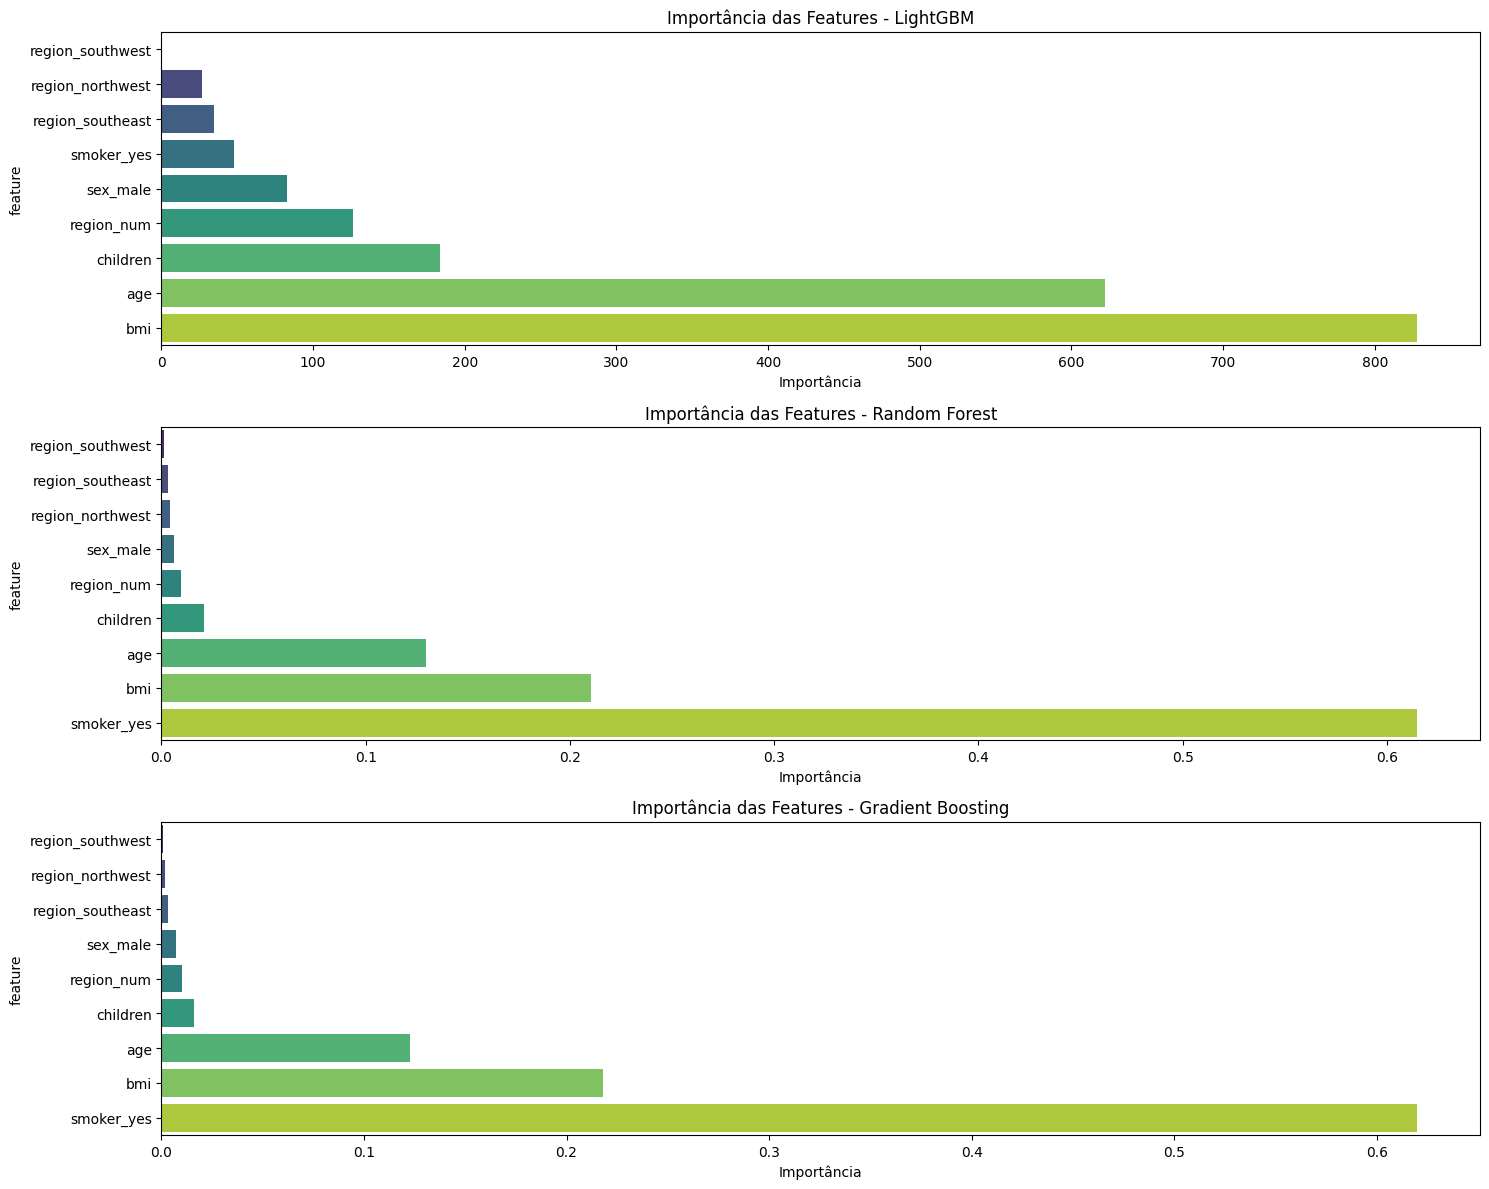

In [18]:
feature_importance_models = ['LightGBM', 'Random Forest', 'Gradient Boosting',]
plt.figure(figsize=(15, len(feature_importance_models) * 4))

for i, model_name in enumerate(feature_importance_models):
    plt.subplot(len(feature_importance_models), 1, i+1)

    # Obter import√¢ncias
    importances = models[model_name].feature_importances_
    feature_names = X.columns

    # Criar DataFrame e ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)

    # Plot
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', hue='feature')
    plt.title(f'Import√¢ncia das Features - {model_name}')
    plt.xlabel('Import√¢ncia')

plt.tight_layout()
plt.show()

Features mais importantes:

- Smoker
- BMI
- Age

üß† O mais interessante √© que o grande campe√£o decidiu focar mais no `bmi` do que na feature `smoker`

# Valida√ß√£o Cruzada

Valida√ß√£o crucial para entendimento de qu√£o bom o nosso modelo est√°. N√£o queremos apenas ter sorte com os dados atuais. Queremos:

- Um modelo bom e validado para os dados atuais ‚úÖ
- Um modelo bom e validado para novos dados üèÜ

Dito isto, vamos fazer uma valida√ß√£o cruzada que testar√° o modelo com diferentes tipos de dados, de modo cruzado, para garantir que o modelo n√£o est√° viciado.

Vamos comparar os top 3 e ver qu√£o s√≥lido eles est√£o.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold  = KFold(n_splits=5, shuffle=True)

random_forest_cross_val = cross_val_score(models['Random Forest'], X, y, cv = kfold)
gradient_boosting_cross_val = cross_val_score(models['Gradient Boosting'], X, y, cv = kfold)
lightgbm_cross_val = cross_val_score(models['LightGBM'], X, y, cv = kfold)

print("\n ----- Random Forest Cross Validation -----")
print("K-Fold (R^2) Scores: {0}".format(random_forest_cross_val))
print("Mean R^2 {0}".format(random_forest_cross_val.mean()))

print("\n ----- Gradient Boosting Cross Validation -----")
print("K-Fold (R^2) Scores: {0}".format(gradient_boosting_cross_val))
print("Mean R^2: {0}".format(gradient_boosting_cross_val.mean()))

print("\n ----- LightGBM Cross Validation -----")
print("K-Fold (R^2) Scores: {0}".format(lightgbm_cross_val))
print("Mean R^2: {0}".format(lightgbm_cross_val.mean()))



 ----- Random Forest Cross Validation -----
K-Fold (R^2) Scores: [0.83022902 0.85957351 0.83982665 0.83815607 0.83033505]
Mean R^2 0.8396240584618779

 ----- Gradient Boosting Cross Validation -----
K-Fold (R^2) Scores: [0.86997787 0.769432   0.76537527 0.80323176 0.87410419]
Mean R^2: 0.8164242188096275

 ----- LightGBM Cross Validation -----
K-Fold (R^2) Scores: [0.8468257  0.82676603 0.84204695 0.86410837 0.8647849 ]
Mean R^2: 0.84890639026491


Insights:

- 85% √© um bom n√∫mero para o modelo e de acordo com algumas refer√™ncias, indica um modelo pronto para ir para produ√ß√£o üöÄ

- Entretanto, podemos tentar otimizar o modelo escolhido para obter uma acur√°cia maior

# O modelo campe√£o

O modelo campe√£o √© o **LightGBM** e vamos test√°-lo e fazer as √∫ltimas valida√ß√µes apenas neste modelo.

O LightGBM √© um framework open source, originalmente criado pela Microsoft e muito utilizado para `regress√£o`, `classifica√ß√£o` e at√© mesmo `ranking`.

Este modelo foi desenhado usando `DecisionTrees`, mas √© muito mais r√°pido e eficiente, especialmente com grandes datasets com uso da GPU e processamento paralelizado.

Algumas refer√™ncias:

- [Documentation](https://lightgbm.readthedocs.io/en/stable/)
- [StatQuest - Gradient Boost Part 1/4](https://www.youtube.com/watch?v=3CC4N4z3GJc) (para entender Gradient Boosting em geral)

# Otimizando o modelo campe√£o

Outro fator importante √© tentar entender como podemos aumentar a performance do modelo ainda mais. Vamos usar o pr√≥prio computador para identificar os melhores par√¢metros para o `LightGBM`.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score #m√©tricas de valida√ß√£o

# Par√¢metros testados
## Chamada original: models['LightGBM'] = LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, verbose=-1)

param_grid = { 'n_estimators':[50, 100, 200], 'max_depth': [3, 6, 9, 12] }
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(LGBMRegressor(), param_grid=param_grid, scoring=gs_metric, cv=5, n_jobs=4, verbose=3)

grid.fit(X_train, y_train)
lightgbm_best_params = grid.best_params_

print("\n ----- LightGBM Best Params ----- \n")
print(lightgbm_best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 ----- LightGBM Best Params ----- 

{'max_depth': 3, 'n_estimators': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Treinando LightGBM Otimizado...

 ----- Results ----- 

                Modelo      R¬≤        MAE           MSE       RMSE
24  LightGBM Optimized  0.9203  2113.1949  1.149508e+07  3390.4399
11            LightGBM  0.8989  2444.1451  1.457925e+07  3818.2781
23            LightGBM  0.8989  2444.1451  1.457925e+07  3818.2781
17       Random Forest  0.8893  2445.1872  1.595701e+07  3994.6227
5        Random Forest  0.8893  2445.1872  1.595701e+07  3994.6227
8    Gradient Boosting  0.8783  2548.6653  1.754775e+07  4189.0033
20   Gradient Boosting  0.8783  2548.6653  1.754775e+07  4189.0033
9             AdaBoost  0.8666  3612.6865  1.922720e+07  4384.8834
21            AdaBoost  0.8666  3612.6865  1.922720e+07  4384.8834
22             XGBoost  0.8593  2746.9017  2.028186e+07  4503.5386
10             XGBoost  0.8593  2746.9017  2.028186e+07  4503.5386
7                  KNN  0.8303  3153.1427  2.446148e+07  4945.8546
19                 KNN  0.8303  3153.1427  2.446148e+07  4945.8546
14  

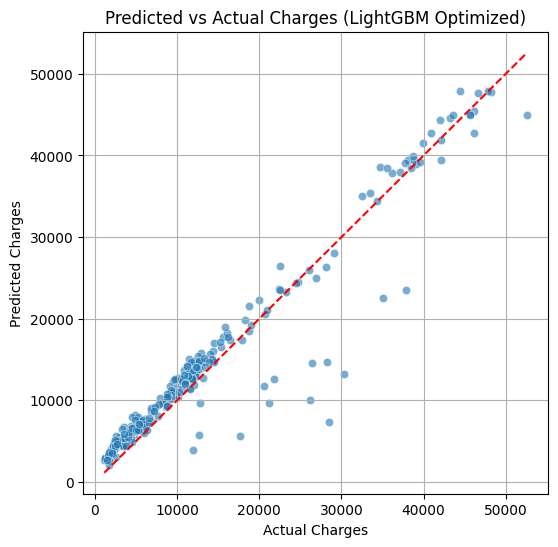

In [21]:
print("\nTreinando LightGBM Otimizado...")
models['LightGBM Optimized'] = LGBMRegressor(n_estimators=50, max_depth=3, random_state=42, verbose=-1)
models['LightGBM Optimized'].fit(X_train, y_train)
lightgbm_optimized_predict = models['LightGBM Optimized'].predict(X_test)

# Apresenta√ß√£o dos modelos
results = get_model_results()
print("\n ----- Results ----- \n")
print(results.round(4))

# Apresenta√ß√£o do gr√°fico
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=lightgbm_optimized_predict, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], '--', color='red')
plt.title("Predicted vs Actual Charges (LightGBM Optimized)")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.grid(True)
plt.show()

O modelo otimizado chegou em 92% no R¬≤. Um aumento significativo comparado ao 84% ~ 85% do modelo anterior.

# Insights e Conclus√£o

Com base neste modelo, podemos dizer:

- Pessoas com mais filhos costumam a gerar menos custos m√©dicos para as seguradoras
- Fumantes tem maiores chances de dobrarem ou triplicarem seus custos m√©dicos
- IMCs acima de 30 (Obesidade) apresentam maiores chances na eleva√ß√£o dos custos m√©dicos
- Homens costumar ter mais custos m√©dicos do que as mulheres
- A regi√£o de `Southeast` apresentou os custos mais caros entre outliers
- A regi√£o de `Northeast` apresentou os custos mais baratos entre outliers
- Com base nestes dados, a regi√£o tem pouca signfic√¢ncia para identifica√ß√£o dos custos

Para uma seguradora, com base nestes dados, o melhor p√∫blico seria:

1. N√£o fumantes
2. Pessoas com IMC abaixo de 30 (Obesidade)
3. Fam√≠lia com muitos filhos
4. Mulheres

E de acordo com a internet, um modelo com 85% de acur√°cia e estes termos de MAE, est√° pronto para ir para produ√ß√£o.

Conseguimos otimizar o nosso modelo para 92% de acur√°cia (R¬≤) e 2113 d√≥lares para a m√©dia de erro e 3390 d√≥lares para o pior cen√°rio, algo em torno de 5,5% comparado ao maior custo, 60k.

Com isso, finalizamos entendendo que o **LightGBM Otimizado** √© o melhor modelo de regress√£o para este problema.